In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
n_rows = 7
n_cols = 10
gridworld = np.zeros((n_rows, n_cols))

In [4]:
init_pos = np.array([3, 0])
goal_pos = np.array([3, 7])

In [5]:
strength = -np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])
wind = np.c_[strength, np.zeros(n_cols)]
wind = np.zeros((n_rows, n_cols, 2)) + wind[None, ...]

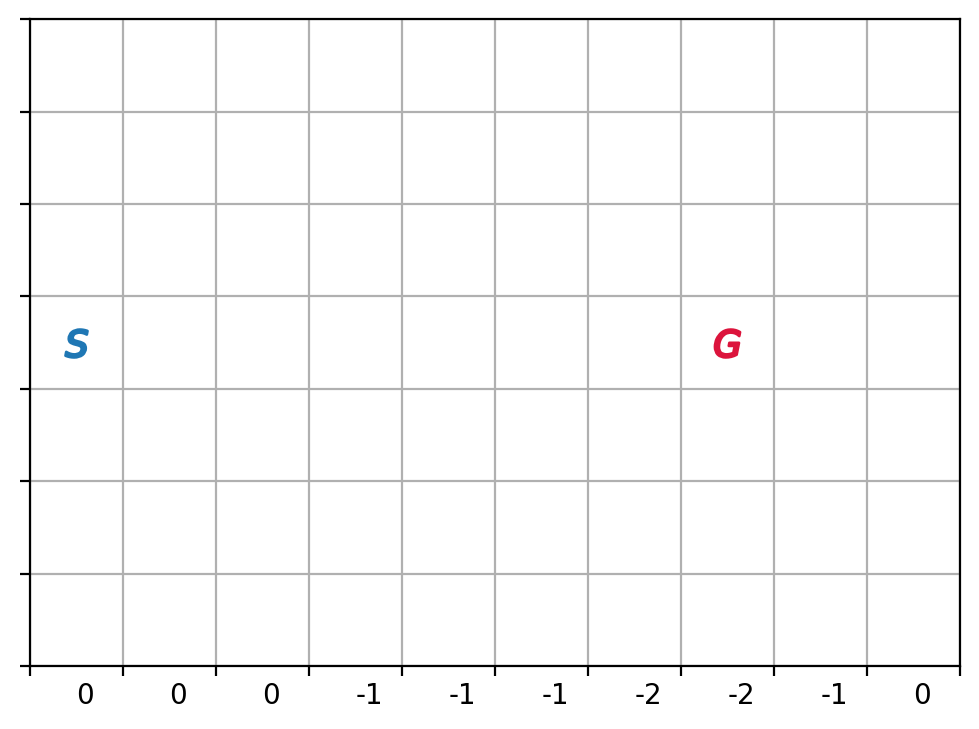

In [6]:
fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.6))
xticks = np.arange(n_cols + 1)
yticks = np.arange(n_rows + 1)

init = init_pos[::-1] + 0.5
goal = goal_pos[::-1] + 0.5
ax.scatter(*init, marker="$S$", s=100)
ax.scatter(*goal, marker="$G$", s =100, c="crimson")
# plt.scatter(*finish_pos)

ax.set_xticks(xticks, labels="")
plt.yticks(yticks, labels="")

# TODO: change for minor xticks
for x, s in enumerate(strength):
    plt.text(x + 0.5, -0.4, s)

plt.grid()

In [7]:
movements = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # up,
    [-1, 0], # down
])
n_actions = len(movements)

In [8]:
@njit
def get_probas(qval, epsilon):
    qmax = qval.max()
    n_actions = len(qval)
    mask = qmax == qval

    if np.all(mask):
        probas = np.ones(n_actions) / n_actions
    elif sum(mask) > 1:
        n_equal = sum(mask)
        probas = epsilon * np.ones(n_actions) /  n_actions
        probas = ((1 - epsilon) / n_actions + epsilon) * mask +  probas * (1 - mask)
    else:
        # return epsilon-greeedy action
        action_max = qval.argmax()
        probas = epsilon * np.ones(n_actions) / n_actions
        probas[action_max] = 1 - epsilon + epsilon / n_actions

    return probas

## Another gridworld

In [9]:
n_rows = 7
n_cols = 10
ixs = np.arange(n_rows * n_cols).reshape(n_rows, n_cols)
ixs

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]])

In [69]:
def wind_strength(n_row, n_col):
    c_strength = 0
    
    if n_col in [3, 4, 5, 8]:
        r_strength =-1
    elif n_col in [6, 7]:
        r_strength = -2
    else:
        r_strength = 0

    move_wind = np.array([r_strength, c_strength])
    return move_wind

In [136]:
# @njit
def get_pos(ix, n_cols):
    col = ix // n_cols
    row = ix % n_cols
    pos = np.array([col, row])
    return pos


# @njit
def get_ix(pos, n_cols):
    row, col = pos
    ix = row * n_cols + col
    return ix


# @njit
def move_pos(pos, step, n_row, n_cols):
    row, col = pos
    row_next, col_next = pos + step
    
    if (row_next < 0) or (row_next >= n_rows):
        row_next = row
    if (col_next < 0) or (col_next >= n_cols):
        col_next = col
    
    pos_next = np.array([row_next, col_next])
    return pos_next


# @njit
def choose_action(ix, Q, epsilon):
    probas = get_probas(Q[ix], epsilon)
    action = np.random.multinomial(1, probas).argmax()
    return action


# @njit
def move_and_reward(
    ix, step, n_rows, n_cols, start_state, end_state, reward_goal, move_fn
):
    ix_new = move_fn(ix, step, n_rows, n_cols) # new s

    reward = -1 if ix != end_state else reward_goal
    ix_new = ix_new if ix != end_state else start_state
    
    # reward = -1 if ix_new != end_state else reward_goal
    # ix_new = ix_new if ix_new != end_state else start_state
    return ix_new, reward


# @njit
def sarsa_step(
    s, a, Q, epsilon, n_rows, n_cols, start_state, end_state, reward_goal, move_fn
):
    # (s, a) -> (r, s_new, a_new)
    step = movements[action]
    s_new, r = move_and_reward(s, step, n_rows, n_cols, start_state, end_state, reward_goal, move_fn)
    a_new = choose_action(s_new, Q, epsilon)

    return r, s_new, a_new

In [137]:
# @njit
def move(ix, step, n_rows, n_cols):
    pos = get_pos(ix, n_cols)
    pos_new = move_pos(pos, step, n_rows, n_cols)
    ix_new = get_ix(pos_new, n_cols)
    return ix_new


def move_wind(ix, step, n_rows, n_cols):
    pos = get_pos(ix, n_cols)
    wind_shift = wind_strength(*pos)
    
    pos_new = move_pos(pos, step + wind_shift, n_rows, n_cols)
    
    ix_new = get_ix(pos_new, n_cols)
    return ix_new

In [138]:
Q = np.zeros((n_rows * n_cols, n_actions)) # action-value function
Q.shape

(70, 4)

In [152]:
epsilon = 0.005
alpha = 0.5
gamma = 1.0
ix = 30
start_state = 30
end_state =  37 #69
action = choose_action(ix, Q, epsilon)

ix_hist = [30]
reward_hist = [0]
reward_goal = 10

for _ in range(20_000):
    r, ix_new, action_new = sarsa_step(ix, action, Q, epsilon, n_rows, n_cols, start_state, end_state, reward_goal, move_wind)
    Q[ix, action] = Q[ix, action] + alpha * (r + gamma * Q[ix_new, action_new] - Q[ix, action])
    ix, action = ix_new, action_new
    ix_hist.append(ix)
    reward_hist.append(r)
ix_hist = np.array(ix_hist)
reward_hist = np.array(reward_hist)

In [153]:
ix_goal = np.where(reward_hist == reward_goal)[0]

pos_hist = np.c_[ix_hist % n_cols, ix_hist // n_cols]
distance_hist = np.abs(pos_hist - get_pos(end_state, n_cols)).sum(axis=1)

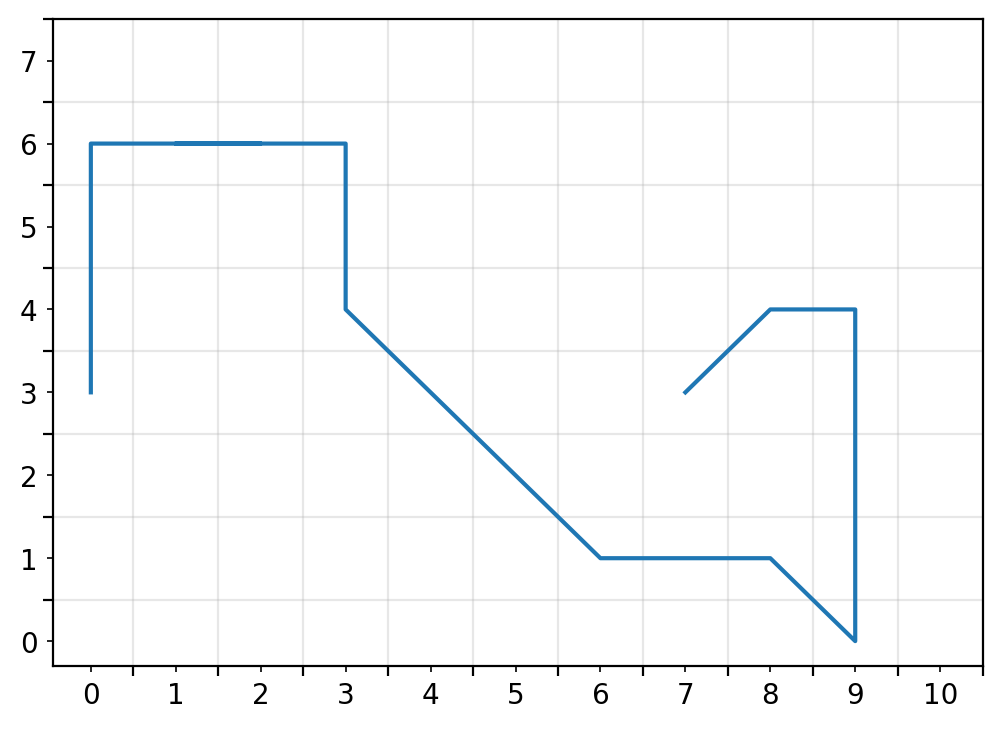

In [155]:
run = -10
iinit = ix_goal[run]
iend = ix_goal[run + 1]

fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.6))
plt.plot(*pos_hist[iinit:iend].T)

xticks = np.arange(n_cols + 1)
yticks = np.arange(n_rows + 1)
ax.set(
    xticks=xticks + 0.5,
    yticks=yticks + 0.5,
    xticklabels="",
    yticklabels="",
)
ax.set_xticks(xticks, labels=xticks, minor=True)
ax.set_yticks(yticks, labels=yticks, minor=True)


plt.grid(alpha=0.3)

In [156]:
distance_hist[-100:]

array([ 5,  7,  7,  7,  9,  9,  9, 10, 10, 10, 11, 11, 11, 13, 12, 11, 10,
        9,  8, 10,  9,  8,  7,  7,  7,  6,  6,  7,  8,  7,  8,  8,  8,  9,
        8,  7,  8,  7,  6,  5,  4,  3,  2,  3,  2,  4,  6,  6,  6,  8,  9,
        9,  9, 10, 11, 11, 11, 12, 13, 12, 11, 11, 11, 10,  9,  8,  8,  7,
        6,  5,  6,  7,  6,  5,  4,  3,  4,  5,  4,  5,  4,  3,  5,  7,  9,
       10, 11, 10, 11, 12, 12, 12, 13, 12, 11, 10, 10, 10, 12, 12])

In [157]:
ix_hist[-100:]

array([45, 25, 25, 25, 16, 16, 16, 17, 17, 17, 18, 18, 18,  9, 19, 29, 39,
       49, 48, 39, 49, 59, 69, 69, 69, 68, 57, 47, 37, 30, 20, 20, 20, 10,
       20, 21, 20, 30, 40, 41, 51, 52, 62, 52, 53, 44, 35, 35, 35, 26,  5,
        5,  5,  6,  7,  7,  7,  8,  9, 19, 29, 29, 29, 39, 49, 48, 37, 30,
       31, 32, 31, 30, 40, 50, 51, 61, 51, 41, 42, 32, 42, 43, 34, 25,  5,
        6,  7,  6,  7,  8,  8,  8,  9, 19, 29, 28, 28, 28,  8,  8])

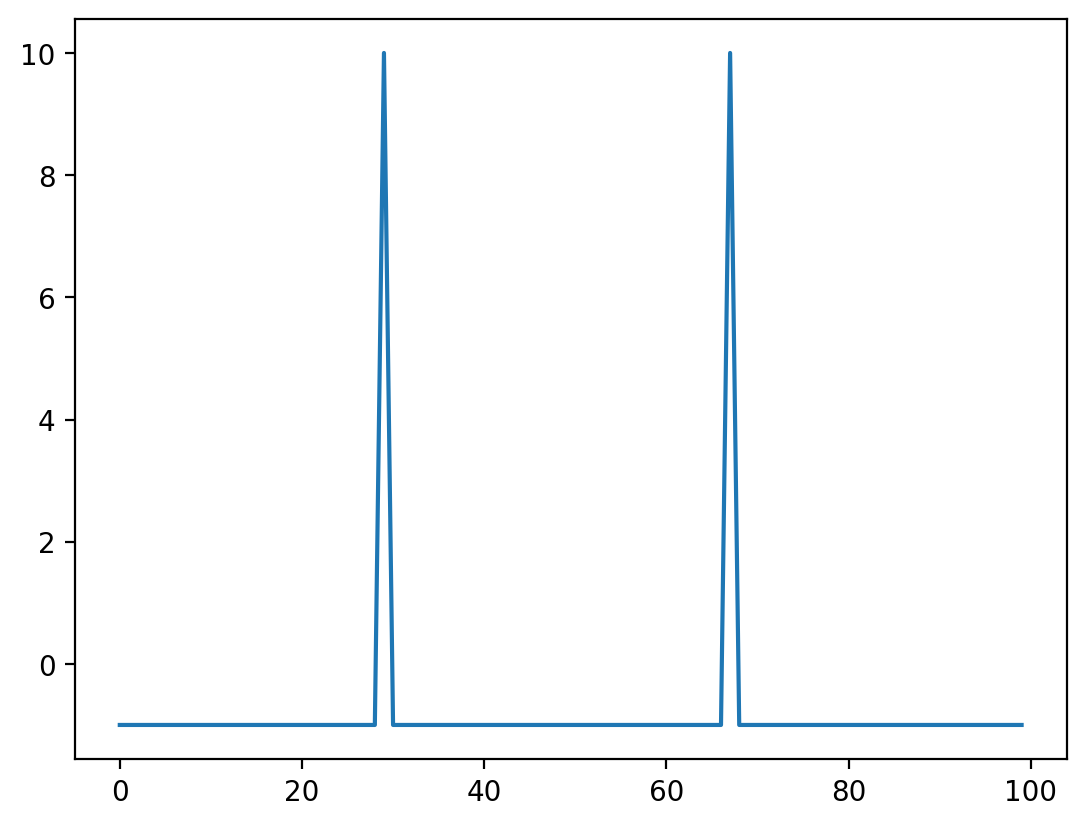

In [158]:
plt.plot(reward_hist[-100:])

In [159]:
ix_goal

array([  555,   655,   739,  1764,  1800,  2132,  2167,  2216,  2273,
        2304,  2326,  2344,  2399,  2439,  2601,  2632,  2708,  2738,
        2796,  2816,  2852,  2870,  2888,  2908,  2928,  2946,  2964,
        2982,  3000,  3018,  3036,  3054,  3075,  3093,  3113,  3133,
        3156,  3176,  3198,  3221,  3241,  3261,  3279,  3301,  3319,
        3338,  3357,  3376,  3395,  3414,  3436,  3455,  3474,  3495,
        3519,  3538,  3557,  3576,  3595,  3617,  3637,  3656,  3675,
        3694,  3713,  3733,  3751,  3769,  3788,  3808,  3827,  3846,
        3891,  3912,  3930,  3952,  3972,  3995,  4014,  4038,  4060,
        4080,  4099,  4122,  4140,  4158,  4176,  4197,  4215,  4233,
        4251,  4269,  4287,  4305,  4323,  4341,  4362,  4384,  4405,
        4423,  4444,  4466,  4487,  4510,  4539,  4584,  4609,  4638,
        4668,  4688,  4735,  4772,  4800,  4825,  4847,  4874,  4909,
        4929,  4955,  4986,  5006,  5026,  5050,  5082,  5105,  5132,
        5154,  5180,

In [160]:
(reward_hist == reward_goal).sum()

511

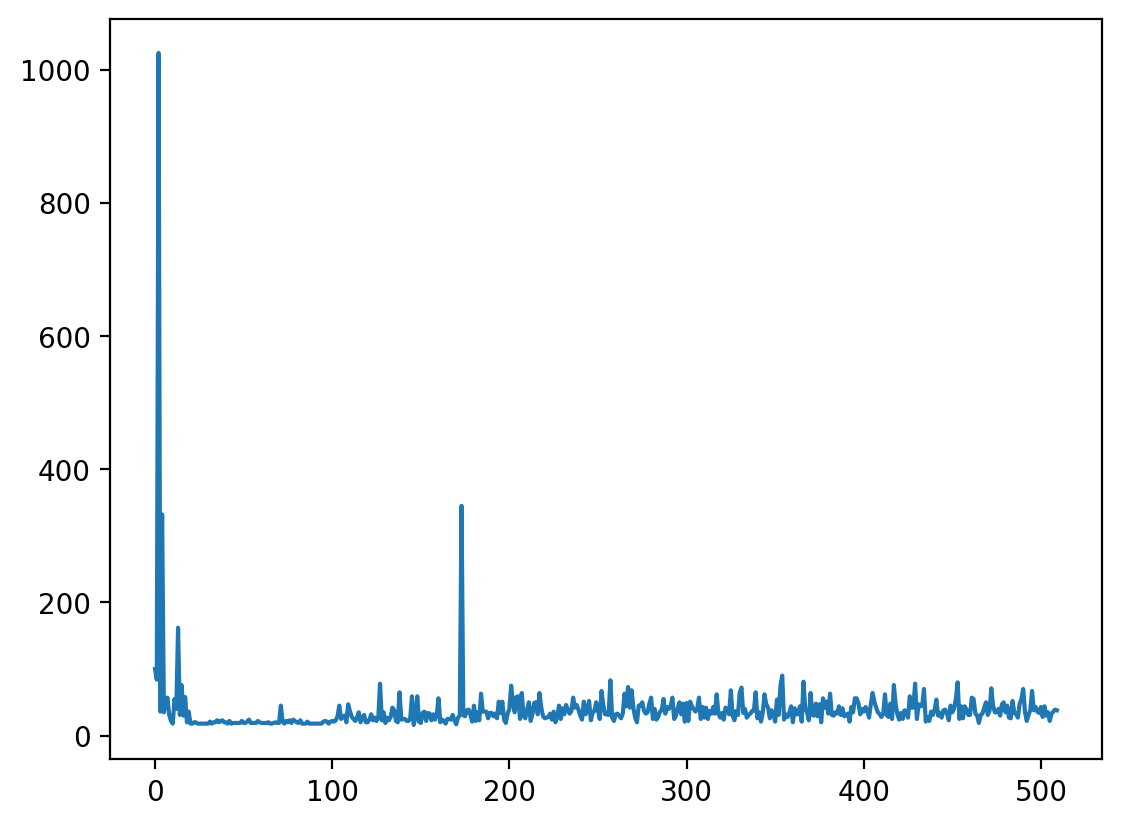

In [161]:
plt.plot(np.diff(ix_goal))
# plt.yscale("log")

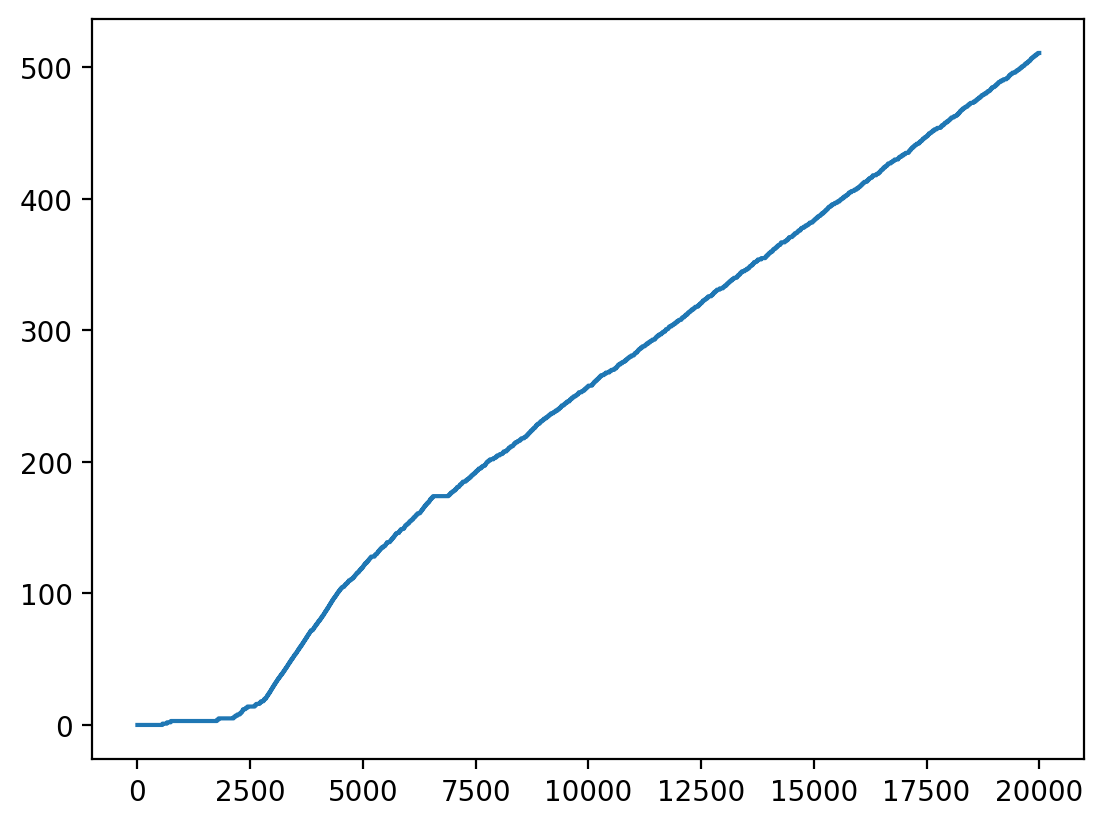

In [162]:
plt.plot((reward_hist == reward_goal).cumsum())